### Import Necessary Module and Set Path 

In [25]:
import sqlite3 as lite
import os
import sys
import collections
import matplotlib.pyplot as plt
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()

In [2]:
import analysis as an
import random_lifetime_extension as rle
import cyclus_input_gen.from_pris as fp
import cyclus_input_gen.demand_deploy as dd
import cyclus_input_gen.find_replace as fr

Usage: from_pris.main([csv],[init_date], [duration], [country_list], [output_file_name])


In [3]:
# also do random lifetime extension of French LWRs to see spread out deployment
# uniform sample (0,25)
rle.generate_input('input.xml', 'rand_ext.xml', 720, 'France', low=0, high=25)

        <name>France_government</name>



In [4]:
! rm rand.sqlite
! cyclus rand_ext.xml -o rand.sqlite

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

In [17]:
# get sqlite cursor and simulation time data
cur = an.cursor('rand.sqlite')
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)

In [18]:
# just france LWR power
power_capacity = an.power_capacity(cur)

power_demand_eq = str(max(power_capacity['France_government']))
print(power_demand_eq)
# with this power capacity, calculate deployment scheme for astrids:
astrid_lifetime = 720
astrid_deployment, powz = dd.get_new_deployment(power_capacity, ['France_government'],
                                                power_demand_eq, 0.6, astrid_lifetime, 840, True)
dd.write_deployinst(astrid_deployment, 'astrid', 'rand_astrid_dep.xml', astrid_lifetime)

64.72999999999999


In [19]:
# add institution wrapper to generated deployinst block
head = """
      <institution>
        <name>France_astrid</name>
        <config>
          <DeployInst>
"""
tail = """

          </DeployInst>
        </config>
      </institution>
"""
with open('rand_astrid_dep.xml') as f:
    read_string = f.read()
    read_string = read_string.replace('<root>', '')
    read_string = read_string.replace('</root>', '')
    tot_string = head + read_string + tail
with open('rand_astrid_dep.xml', 'w') as f:
    f.write(tot_string)

In [20]:
# insert astrid block
with open('rand_ext.xml') as f:
    input_string = f.read()

insert_start = """          </DeployInst>
        </config>
      </institution>"""


insert_end = """      <institution>
        <name>France_government</name>
        <config>
"""

new_input = fr.replace_file(input_string, insert_start, insert_end, 'rand_astrid_dep.xml', insert=True)
print(len(new_input))
with open('rand_input_astrid.xml', 'w') as f:
    f.write(new_input)

195255
209062
245693


In [21]:
# run the new input with astrid reactors
! rm rand_ext_output.sqlite
! cyclus rand_input_astrid.xml -o rand_ext_output.sqlite

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

In [22]:
# get sqlite cursor and simulation time data
cur = an.cursor('rand_ext_output.sqlite')
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)

In [23]:
power_cap = an.power_capacity(cur)
dictionary = {'lwr': power_cap['France_government'],
              'astrid': power_cap['France_astrid']}
init_year, init_month, duration, timestep = an.simulation_timesteps(cur)
an.stacked_bar_chart(dictionary, timestep,
                  'Years', 'Net_Capacity [GWe]',
                  'Net Capacity vs Time',
                  'rand_ext_france_power_plot', init_year)

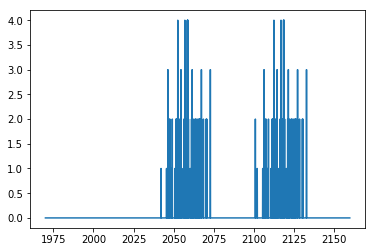

107
Average number of ASTRIDS to deploy per year
1.7666666666666666


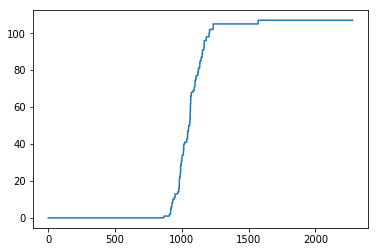

In [26]:
# astrid deployment
entry = cur.execute('SELECT entertime FROM agententry WHERE prototype == "astrid"').fetchall()
num_dict = {}
cum_dict = {}
num_dict['num dep'] = []
for t in timestep:
    astrid_num = 0
    for agent in entry:
        if agent['entertime'] == t:
            astrid_num += 1
    num_dict['num dep'].append(astrid_num)
dep = an.deployments(cur)
cum_dict['cumulative'] = dep['France_astrid']
plt.plot(init_year + timestep/12, num_dict['num dep'])
plt.show()
plt.close()
plt.plot(cum_dict['cumulative'])
print(max(cum_dict['cumulative']))

print('Average number of ASTRIDS to deploy per year')
print(sum(num_dict['num dep']) / (2160-2040) )
an.double_axis_bar_line_plot(num_dict, cum_dict, timestep,
                             'Years', 'Number of SFRs Deployed', ' Number of SFRs Operational',
                             'Build number and cumulative ASTRID Number vs Time', 'rand_sfr_deploy',
                             init_year)